In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("dat.csv")
df = df.drop(['employees_created'], axis=1)
df = df.drop(['employee_id'], axis=1)
df["age"] = df["age"].fillna(df["age"].mean())
from sklearn.preprocessing import LabelEncoder
df_a = df.copy()

# Create a label encoder object
le = LabelEncoder()
le_count = 0

le.fit(df_a['influx_route_big'])
# Transform both training and testing data
df_a['influx_route_big'] = le.transform(df_a['influx_route_big'])
df_b = pd.get_dummies(df_a['influx_route_big'], drop_first = True)

# one-hot encoding of categorical variables
df_b.columns = ['influx_0','influx_1','influx_2','influx_3','influx_4','influx_5','influx_6','influx_7']
df = pd.concat([df, df_b], axis=1)

df = df.drop(['influx_route_big'], axis=1)
pd.set_option('display.max_columns', 100)
df.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,influx_0,influx_1,influx_2,influx_3,influx_4,influx_5,influx_6,influx_7
0,26.0,0,5,5,5,11,15,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
1,25.0,1,8,8,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,24.0,1,3,3,2,0,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,25.0,1,3,3,4,7,56,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
4,26.0,1,4,4,3,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


In [3]:
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search# Make the random forest classifier

parameters = {
        'n_estimators'      : [5, 10, 30],
        'max_features'      : [3, 5, 10],
        'random_state'      : [0],
        'n_jobs'            : [1],
        'min_samples_split' : [3, 5, 10],
        'max_depth'         : [3, 5, 10]
}
#ValueError: max_features must be in (0, n_features]
random_forest = grid_search.GridSearchCV(RandomForestClassifier(), parameters)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
# Train on the training data
model = random_forest.fit(X_train, y_train)

In [6]:
print(random_forest.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


In [7]:
from sklearn import metrics as mtr

prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = mtr.roc_curve(y_test, prob, pos_label=1)
mtr.auc(fpr, tpr)

0.7371036154248335

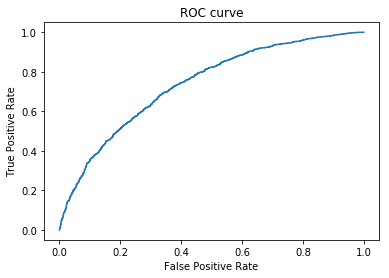

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [9]:
class_predict = model.predict(X_test)
# 精度を計算してみます。
print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))
print('テストデータに対する roc-auc： %.4f' %mtr.roc_auc_score(y_test, prob))
print('テストデータに対する log-loss： %.4f' %mtr.log_loss(y_test, prob))

テストデータに対する正解率： 0.6990
テストデータに対する roc-auc： 0.7371
テストデータに対する log-loss： 0.5828


## 重要な特徴量を見つける

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf = clf_rf.fit(X_train, y_train)

#Feature Importance
fti = clf_rf.feature_importances_   
print(fti)

[1.13096468e-01 2.88446523e-02 9.12677112e-02 9.27236709e-02
 9.44564280e-02 1.00560476e-01 1.46457446e-01 2.22647083e-02
 1.71743450e-02 1.69167483e-02 1.46423609e-02 1.26178204e-02
 1.94494165e-02 1.76697500e-02 4.02617776e-03 6.17567584e-03
 3.33562651e-03 4.16914462e-02 5.94154616e-03 3.85360939e-02
 5.02811766e-02 1.66632933e-03 1.60535760e-02 2.84541139e-03
 1.79935563e-05 1.89176181e-02 4.27735784e-04 1.45396881e-02
 7.40190189e-03]


In [11]:
df_train.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,influx_0,influx_1,influx_2,influx_3,influx_4,influx_5,influx_6,influx_7
0,26.0,0,5,5,5,11,15,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
1,25.0,1,8,8,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,24.0,1,3,3,2,0,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,25.0,1,3,3,4,7,56,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
4,26.0,1,4,4,3,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


やっぱり、登録してからの日にちと、こちらからのアクションに対する反応（通電or受電）とかで変わってきそう

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


1   owned_visit   0.14645744642711286
2   age   0.11309646847211101
3   mail_click   0.10056047629254279
4   open_count   0.09445642795825589
5   interview_date_diffs   0.09272367091669104
6   entry_date_diffs   0.09126771116719311
7   contact_result_5   0.05028117655782198
8   contact_result_1   0.04169144623410344
9   contact_result_4   0.038536093923517235
10   gender   0.02884465227763692
11   advertisement   0.022264708266243924
12   now_status_1   0.01944941652302536
13   influx_4   0.018917618126926113
14   now_status_2   0.01766974997726231
15   career_change_desired_date_1   0.01717434504347158
16   career_change_desired_date_2   0.01691674825883147
17   influx_1   0.016053575989706442
18   career_change_desired_date_3   0.014642360892037059
19   influx_6   0.01453968809466151
20   career_change_desired_date_4   0.012617820378685151
21   influx_7   0.007401901888613484
22   now_status_4   0.006175675843031044
23   contact_result_2   0.005941546161044463
24   now_status_3   0.0

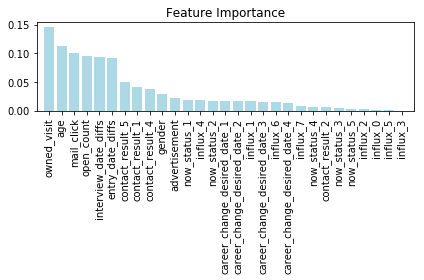

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
#特徴量の重要度
feature = clf_rf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
X_1 = df_train.drop("objective_variable" , axis=1)
label = X_1.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print (str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

In [19]:
# 多重共線性のテスト
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1)
X = X.drop("interview_date_diffs" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search# Make the random forest classifier

parameters = {
        'n_estimators'      : [5, 10, 30],
        'max_features'      : [3, 5, 10],
        'random_state'      : [0],
        'n_jobs'            : [1],
        'min_samples_split' : [3, 5, 10],
        'max_depth'         : [3, 5, 10]
}
#ValueError: max_features must be in (0, n_features]
random_forest = grid_search.GridSearchCV(RandomForestClassifier(), parameters)

# Train on the training data
model = random_forest.fit(X_train, y_train)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


1   advertisement   0.13965460453101358
2   age   0.1124820423366264
3   owned_visit   0.097343380486098
4   open_count   0.09591878621866996
5   entry_date_diffs   0.09540876754247664
6   mail_click   0.09474495506356673
7   objective_variable   0.05071625673384674
8   contact_result_2   0.044431226729944095
9   contact_result_5   0.033520292183427405
10   gender   0.026039061111989066
11   career_change_desired_date_1   0.02431082300403479
12   influx_4   0.02199538564228843
13   career_change_desired_date_2   0.019554115837077404
14   career_change_desired_date_3   0.0186702586494862
15   influx_1   0.01762914742011775
16   now_status_2   0.01623548526379662
17   influx_6   0.016211847543978242
18   now_status_1   0.014934864893998598
19   career_change_desired_date_4   0.01328850226368743
20   now_status_3   0.01230627501964869
21   influx_7   0.008370321554509884
22   now_status_5   0.006880616156606889
23   contact_result_4   0.006539013697130304
24   now_status_4   0.00390328168

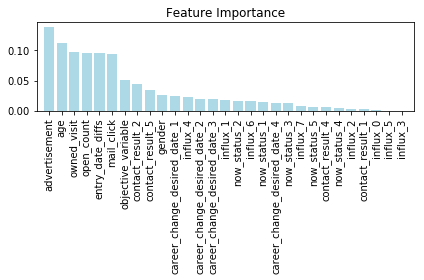

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
#特徴量の重要度
feature = clf_rf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
X_1 = df_train.drop("objective_variable" , axis=1)
X_1 = df_train.drop("interview_date_diffs" , axis=1)
label = X_1.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print (str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

In [17]:
X_1.columns[0:]

Index(['age', 'gender', 'entry_date_diffs', 'open_count', 'mail_click',
       'owned_visit', 'advertisement', 'career_change_desired_date_1',
       'career_change_desired_date_2', 'career_change_desired_date_3',
       'career_change_desired_date_4', 'now_status_1', 'now_status_2',
       'now_status_3', 'now_status_4', 'now_status_5', 'contact_result_1',
       'contact_result_2', 'contact_result_4', 'contact_result_5',
       'objective_variable', 'influx_0', 'influx_1', 'influx_2', 'influx_3',
       'influx_4', 'influx_5', 'influx_6', 'influx_7'],
      dtype='object')

In [18]:
X_1.head()

,age,gender,entry_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,influx_0,influx_1,influx_2,influx_3,influx_4,influx_5,influx_6,influx_7
0,26.0,0,5,5,11,15,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
1,25.0,1,8,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,24.0,1,3,2,0,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,25.0,1,3,4,7,56,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
4,26.0,1,4,3,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


In [23]:
df_train.shape

(12144, 30)